## Importing Libraries

In [7]:
import os
import time
import random
import shutil
import zipfile
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Dataset

In [ ]:
# from google.colab import files
# files.upload() #upload kaggle.json

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair -p /tmp/

100% 11.6G/11.6G [04:44<00:00, 58.1MB/s]



In [5]:
local_training_zip = '/tmp/anime-sketch-colorization-pair.zip'
if zipfile.is_zipfile(filename=local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r', compression=0, allowZip64=True)
    zip_ref.extractall(path='/tmp/')
    zip_ref.close()

In [6]:
# removing unwanted data
os.remove(path=local_training_zip)

tmp1 = '/tmp/data/colorgram/'
for i in os.listdir(path=tmp1):
    os.remove(path=tmp1+i)
os.rmdir(path=tmp1)

tmp2 = '/tmp/data/data/'
for i in os.listdir(path=tmp2):
    tmp2_sub = tmp2+i+'/'
    for j in os.listdir(path=tmp2_sub):
        os.remove(path=tmp2_sub+j)
    os.rmdir(path=tmp2_sub)
os.rmdir(path=tmp2)

## Analyzing Dataset

In [8]:
train_dir = '/tmp/data/train/'
val_dir = '/tmp/data/val/'

In [9]:
print('Number of Training Images:', len(os.listdir(train_dir)))
print('Number of Validation Images:', len(os.listdir(val_dir)))

Number of Training Images: 14224
Number of Validation Images: 3545


Random 5 images from training set


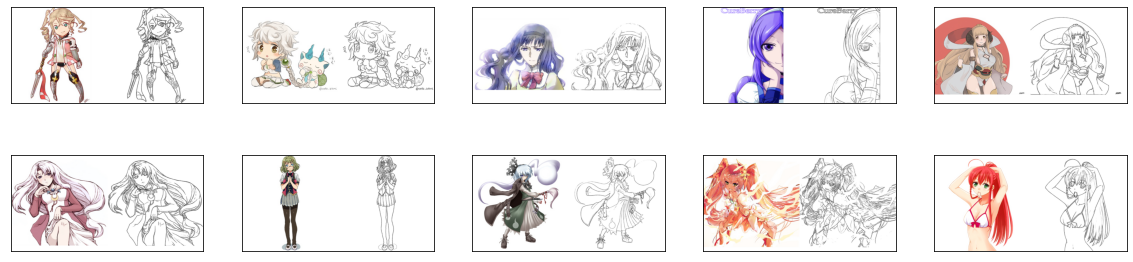

In [10]:
print('Random 5 images from training set')
plt.figure(figsize=(20, 5))

for i in range(1, 11):
    img_name = random.choice(os.listdir(train_dir))
    img = plt.imread(train_dir + img_name)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [11]:
# randomly selecting a image & checking for dimensions
img_name = random.choice(os.listdir(train_dir))
img = plt.imread(train_dir + img_name)
img.shape

(512, 1024, 3)

In [12]:
# no need for normalizing
print('Minimum Value:', np.min(img))
print('Maximum Value:', np.max(img))

Minimum Value: 0.0
Maximum Value: 1.0


In [13]:
# getting half image attr
divider = img.shape[1]//2
divider

512

In [14]:
img_shape = img.shape
epochs = 10

## Splitting Dataset

+ It takes a long time & will eventually run out of resoures.
+ So, this approach doesn't work.

In [15]:
# def split_image(img_dir, divider, dir1, dir2):
#     '''
#         Input: img_dir => Image Directory
#                divider => for dividing image into two
#                dir1 => dir for storing first part of image
#                dir2 => dir for storing second part of image
#         Output: Splits and saves divided images into resp. dirs
#     '''
#     for img_name in tqdm(os.listdir(path=img_dir)):
#         img = plt.imread(train_dir + img_name)
#         plt.imsave(fname=dir1+'/'+img_name, arr=img[:, :divider, :])
#         plt.imsave(fname=dir1+'/'+img_name, arr=img[:, divider:, :])

In [16]:
# os.mkdir(path=train_dir+'x')
# os.mkdir(path=train_dir+'y')
# split_image(img_dir=train_dir, divider=divider, dir1=train_dir+'x', dir2=train_dir+'y')

# os.mkdir(path=test_dir+'x')
# os.mkdir(path=test_dir+'y')
# split_image(img_dir=test_dir, divider=divider, dir1=test_dir+'x', dir2=test_dir+'y')

## Approach-1

+ Taking 'RGB' color code into consideration.

### Defining Model

+ Input: Whole Image as it is (half: target, half: source)
+ Output: Only target

In [17]:
class ConvolutionAutoEncoder(tf.keras.Model):
    '''Convolutional AutoEncoder'''
    
    def __init__(self, original_dim, split=True, encoding_part=1):
        '''
            Input: original_dim => Input Dimension
                   split => splitting point
            Output: It creates the architecture based on inputs
        '''
        super(ConvolutionAutoEncoder, self).__init__(name='CAE')
        self.split = split
        self.encoding_part = encoding_part

        if self.split:
            self.inputShape = (original_dim[0], original_dim[1]//2, original_dim[-1])
        else:
            self.inputShape = original_dim
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.inputShape),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        ], name='Encoder')
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.encoder.output.shape[1:]),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=original_dim[-1], kernel_size=(3, 3), padding='same', activation='sigmoid'),
        ], name='Decoder')

        super(ConvolutionAutoEncoder, self).build((None, *original_dim))

     
    def encode(self, input_features, split_needed=False, encoding_part=1):
        '''
           passes input to encoder & it's output gets splits into mean and logvar 
        '''
        if split_needed:
            return self.encoder(tf.split(input_features, num_or_size_splits=2, axis=2)[self.encoding_part])
        else:
            return self.encoder(input_features)
    
    
    def decode(self, encodings):
        '''
            returns decoder's output
        '''
        return self.decoder(encodings)
    
    
    def call(self, input_features):
        '''
            Feeds input-data to the model architecture
        '''
        encodings = self.encode(input_features, split_needed=self.split, encoding_part=self.encoding_part)
        return self.decode(encodings)

### Initializing Model

In [18]:
autoencoder = ConvolutionAutoEncoder(original_dim=img_shape, split=True, encoding_part=1)

In [19]:
autoencoder.summary()

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Sequential)         (None, 512, 512, 256)     388416    
_________________________________________________________________
Decoder (Sequential)         (None, 512, 512, 3)       388163    
Total params: 776,579
Trainable params: 776,579
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoencoder.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 256)     295168    
Total params: 388,416
Trainable params: 388,416
Non-trainable params: 0
_________________________________________________________________


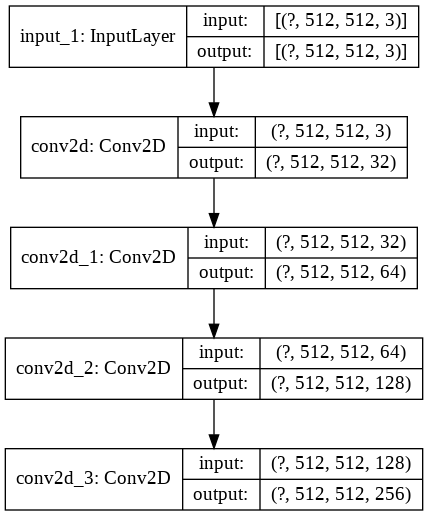

In [21]:
tf.keras.utils.plot_model(
    model=autoencoder.encoder,
    to_file='AutoEncoder-Encoder.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)

In [22]:
autoencoder.decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 64)      73792     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 512, 512, 32)      18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 512, 512, 3)       867       
Total params: 388,163
Trainable params: 388,163
Non-trainable params: 0
_________________________________________________________________


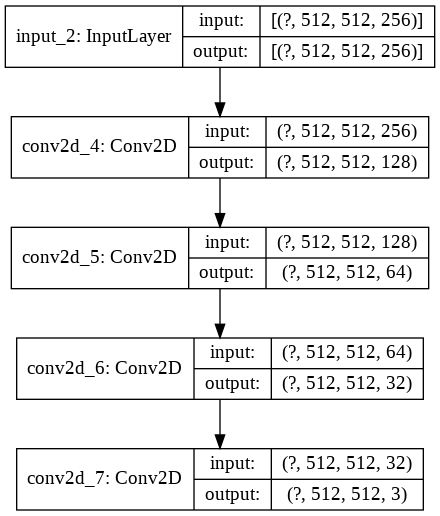

In [23]:
tf.keras.utils.plot_model(
    model=autoencoder.decoder,
    to_file='AutoEncoder-Decoder.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)

### Manual Training

#### Defining Loss Function

In [24]:
def model_loss(model, original):
    '''
        Returns loss defined for the model
    '''
    tmp = tf.split(original, num_or_size_splits=2, axis=2)[0]
    return tf.reduce_mean(tf.square(tf.subtract(model(original), tmp)))

#### Defining Training Process

In [25]:
# @tf.function
def train_model(loss, model, optimizer, original):
    '''
        Trains the model by computing loss and gradients
    '''
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        optimizer.apply_gradients(gradient_variables)

#### Defining Optimizer

In [26]:
opt = tf.optimizers.Adam(learning_rate=0.001)

#### Building Data Generator

In [27]:
def generator(data_dir, batch_size, steps_per_epoch):
    for _ in range(steps_per_epoch):
        images = []
        for i in range(batch_size):
            img_name = random.choice(os.listdir(path=data_dir))
            images.append(plt.imread(fname=data_dir+img_name))
        images = np.array(images)
        yield images

#### Training Model

In [28]:
steps = 5

for epoch in range(epochs):
    start = time.time()
    for batch_input in tqdm(generator(data_dir=train_dir, batch_size=2, steps_per_epoch=steps), desc='Epoch - '+str(epoch+1), total=steps):
        train_model(loss=model_loss, model=autoencoder, optimizer=opt, original=batch_input)
    end = time.time()
    
    print('Loss:', float(model_loss(model=autoencoder, original=batch_input)), end='\t')
    print('Time-Elapsed:', (end-start))


Loss: 0.04706298187375069	Time-Elapsed: 25.85960555076599



Loss: 0.06652965396642685	Time-Elapsed: 5.302898168563843



Loss: 0.08844544738531113	Time-Elapsed: 5.2420899868011475



Loss: 0.15164898335933685	Time-Elapsed: 5.256662130355835



Loss: 0.08373603224754333	Time-Elapsed: 5.218376636505127



Loss: 0.13015498220920563	Time-Elapsed: 5.190168142318726



Loss: 0.07604324072599411	Time-Elapsed: 5.217961072921753



Loss: 0.07747780531644821	Time-Elapsed: 5.255012273788452



Loss: 0.070241779088974	Time-Elapsed: 5.208386659622192



Loss: 0.13293085992336273	Time-Elapsed: 5.198551177978516


#### Analyzing Model

In [29]:
pred = autoencoder.predict(x=generator(data_dir=val_dir, batch_size=2, steps_per_epoch=10))
pred.shape

(20, 512, 512, 3)

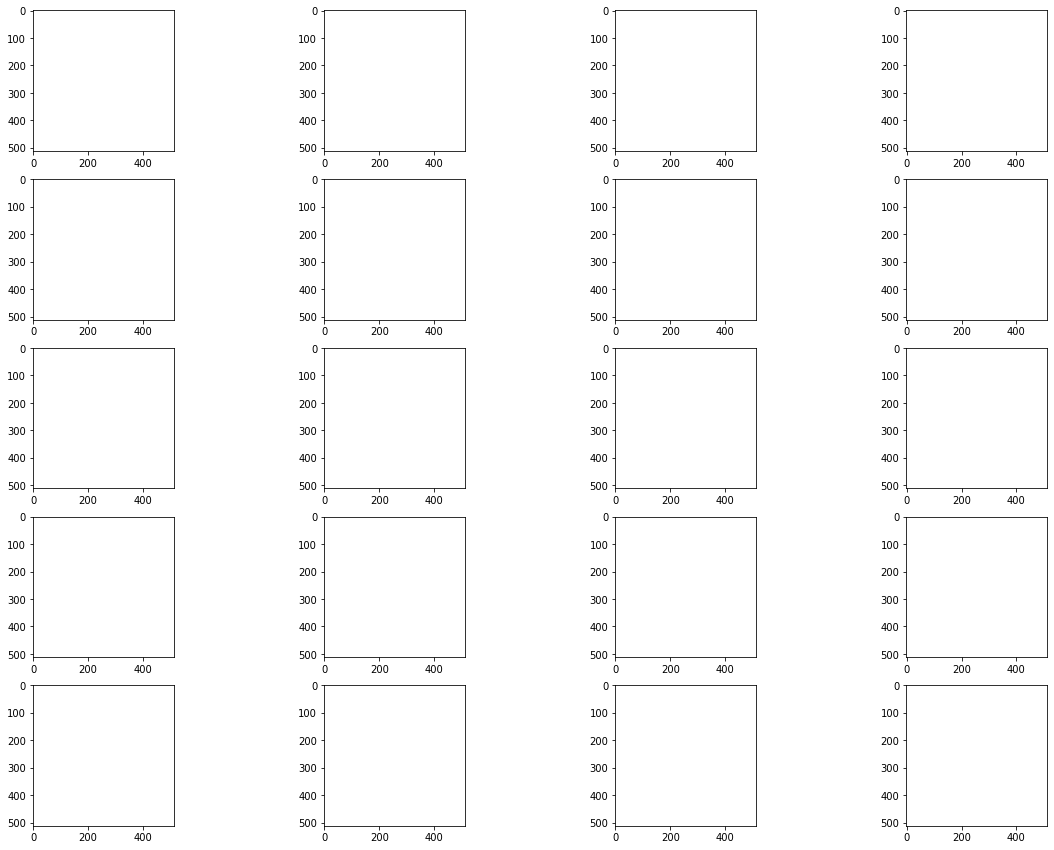

In [30]:
plt.figure(figsize=(20, 15))
for j, i in enumerate(pred):
    plt.subplot(5, 4, j+1)
    plt.imshow(X=i)

### Custom Training

#### Building Data Generator

##### Default Generator

+ This doesn't work as expected

In [31]:
# def shift(directory):
#     lst = os.listdir(directory)
#     os.mkdir(directory+'temp')
#     for i in lst:
#         shutil.move(directory+i, directory+'temp/'+i)

# shift(directory=train_dir)
# shift(directory=val_dir)

In [32]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1/255,
#     fill_mode='nearest'
# )

# train_generator = train_datagen.flow_from_directory(
#     directory=train_dir,
#     target_size=img_shape[:-1],
#     color_mode='rgb',
#     classes=None,
#     class_mode=None,
#     batch_size=32,
#     shuffle=True,
#     interpolation='nearest'
# )

# # Validation data
# validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1/255,
#     fill_mode='nearest'
# )

# validate_generator = validate_datagen.flow_from_directory(
#     directory=val_dir,
#     target_size=img_shape[:-1],
#     color_mode='rgb',
#     classes=None,
#     class_mode=None,
#     batch_size=32,
#     shuffle=True,
#     interpolation='nearest'
# )

##### Custom Generator

In [33]:
def generator(data_dir, batch_size):
    last = len(os.listdir(data_dir))//batch_size
    for _ in range(last):
        images = []
        for i in range(batch_size):
            img_name = random.choice(os.listdir(path=data_dir))
            images.append(plt.imread(fname=data_dir+img_name))
        images = np.array(images)
        yield (images, images)

#### Defining Loss Function

In [34]:
def model_loss(y_true, y_pred):
    '''
        Returns loss defined for the model
    '''
    tmp = tf.split(y_true, num_or_size_splits=2, axis=2)[0]
    return tf.reduce_mean(tf.square(tf.subtract(y_pred, tmp)))

#### Defining Optimizer

In [35]:
autoencoder.compile(optimizer='adam', loss=model_loss)

#### Training Model

In [36]:
autoencoder.fit(
    generator(data_dir=train_dir, batch_size=2),
    epochs=10,
    steps_per_epoch=10
)

Epoch 1/10
10/10 [==============================] - 10s 1s/step - loss: 0.0833
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 0.0819
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.0898
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.1045
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.0859
Epoch 6/10
10/10 [==============================] - 10s 1s/step - loss: 0.0828
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 0.0644
Epoch 8/10
10/10 [==============================] - 10s 1s/step - loss: 0.1003
Epoch 9/10
10/10 [==============================] - 10s 1s/step - loss: 0.0813
Epoch 10/10
10/10 [==============================] - 10s 1s/step - loss: 0.0880


#### Analyzing Model

In [37]:
pred = autoencoder.predict(x=generator(data_dir=val_dir, batch_size=2), verbose=2, steps=10)
pred.shape

10/10 - 4s


(20, 512, 512, 3)

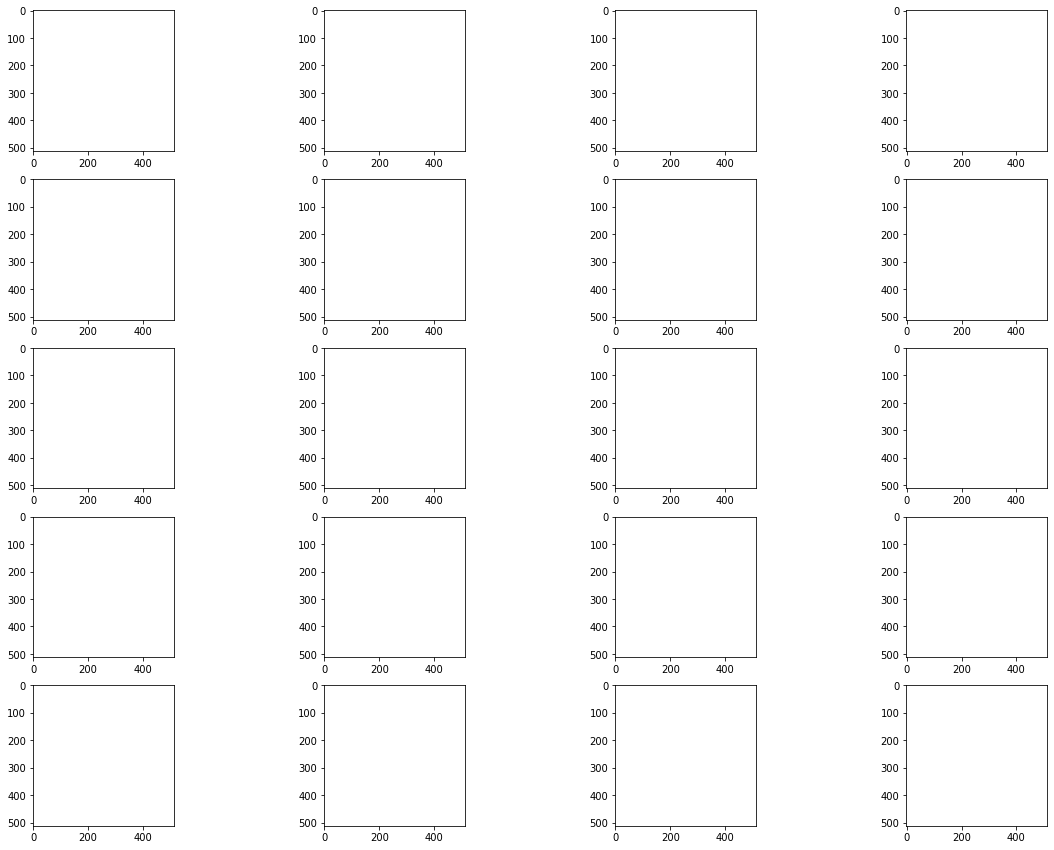

In [38]:
plt.figure(figsize=(20, 15))
for j, i in enumerate(pred):
    plt.subplot(5, 4, j+1)
    plt.imshow(X=i)

## Approach-2

+ Taking 'LAB' color code into consideration

### Loading Dataset

In [39]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [40]:
def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2

    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]

    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))

    # for diversity
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [41]:
import glob
train_dir = glob.glob('/tmp/data/train/*.png')

In [42]:
dataset = tf.data.Dataset.from_tensor_slices(train_dir)

In [43]:
train = dataset.map(map_func=load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

In [44]:
BATCH_SIZE = 8
BUFFER_SIZE = 20

In [45]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Building Model

In [46]:
class ConvolutionAutoEncoder(tf.keras.Model):
    '''Convolutional AutoEncoder'''
    
    def __init__(self, original_dim, split=True, encoding_part=1):
        '''
            Input: original_dim => Input Dimension
                   split => splitting point
            Output: It creates the architecture based on inputs
        '''
        super(ConvolutionAutoEncoder, self).__init__(name='CAE')
        self.split = split
        self.encoding_part = encoding_part

        if self.split:
            self.inputShape = (original_dim[0], original_dim[1]//2, original_dim[-1])
        else:
            self.inputShape = original_dim
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.inputShape),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        ], name='Encoder')
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.encoder.output.shape[1:]),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=original_dim[-1], kernel_size=(3, 3), padding='same', activation='sigmoid'),
        ], name='Decoder')

        super(ConvolutionAutoEncoder, self).build((None, *original_dim))

     
    def encode(self, input_features, split_needed=False, encoding_part=1):
        '''
           passes input to encoder & it's output gets splits into mean and logvar 
        '''
        if split_needed:
            return self.encoder(tf.split(input_features, num_or_size_splits=2, axis=2)[self.encoding_part])
        else:
            return self.encoder(input_features)
    
    
    def decode(self, encodings):
        '''
            returns decoder's output
        '''
        return self.decoder(encodings)
    
    
    def call(self, input_features):
        '''
            Feeds input-data to the model architecture
        '''
        encodings = self.encode(input_features, split_needed=self.split, encoding_part=self.encoding_part)
        return self.decode(encodings)

In [47]:
autoencoder = ConvolutionAutoEncoder(original_dim=(256, 256, 3), split=False, encoding_part=1)

In [48]:
autoencoder.summary()

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Sequential)         (None, 256, 256, 256)     388416    
_________________________________________________________________
Decoder (Sequential)         (None, 256, 256, 3)       388163    
Total params: 776,579
Trainable params: 776,579
Non-trainable params: 0
_________________________________________________________________


In [49]:
autoencoder.compile(optimizer='adam', loss='mse')

In [51]:
autoencoder.fit(
    train_dataset,
    steps_per_epoch=20,
    epochs=5
)

Epoch 1/5
20/20 [==============================] - 20s 980ms/step - loss: 50948.9180
Epoch 2/5
20/20 [==============================] - 20s 982ms/step - loss: 51320.0508
Epoch 3/5
20/20 [==============================] - 20s 978ms/step - loss: 51185.5000
Epoch 4/5
20/20 [==============================] - 20s 979ms/step - loss: 50980.8906
Epoch 5/5
20/20 [==============================] - 20s 982ms/step - loss: 50938.3125


In [54]:
pred = autoencoder.predict(train_dataset, batch_size=4, steps=10)
pred.shape

(80, 256, 256, 3)

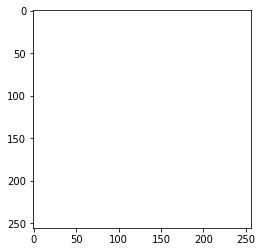

In [55]:
plt.imshow(pred[0])